## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import locCSN
import matplotlib.pyplot as plt
# print(anndata.__version__)

## 2. Load data 

In [3]:
adata = sc.read('PDAC.h5ad') 

In [4]:
adata

AnnData object with n_obs × n_vars = 57530 × 24005
    obs: 'cluster'

In [5]:
adata.obs.head()

cluster
cell.name                            
T1_AAACCTGAGATGTCGG   Fibroblast cell
T1_AAACGGGGTCATGCAT     Stellate cell
T1_AAAGATGCATGTTGAC   Macrophage cell
T1_AAAGATGGTCGAGTTT   Macrophage cell
T1_AAAGATGGTCTCTCTG  Endothelial cell

In [6]:
adata.var.head()

Empty DataFrame
Columns: []
Index: [AL627309.1, AP006222.2, RP11-206L10.3, RP11-206L10.2, RP11-206L10.9]

In [7]:
adata.X.shape

(57530, 24005)

## 3. QC

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# we now have many additional data types in the obs slot:
adata

AnnData object with n_obs × n_vars = 57530 × 24005
    obs: 'cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [9]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

print(sum(mito_genes))

13


In [10]:
# Also calculate percent malat1
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))

adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)

103


In [11]:
adata

AnnData object with n_obs × n_vars = 57530 × 24005
    obs: 'cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'percent_mito', 'n_counts', 'percent_ribo'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

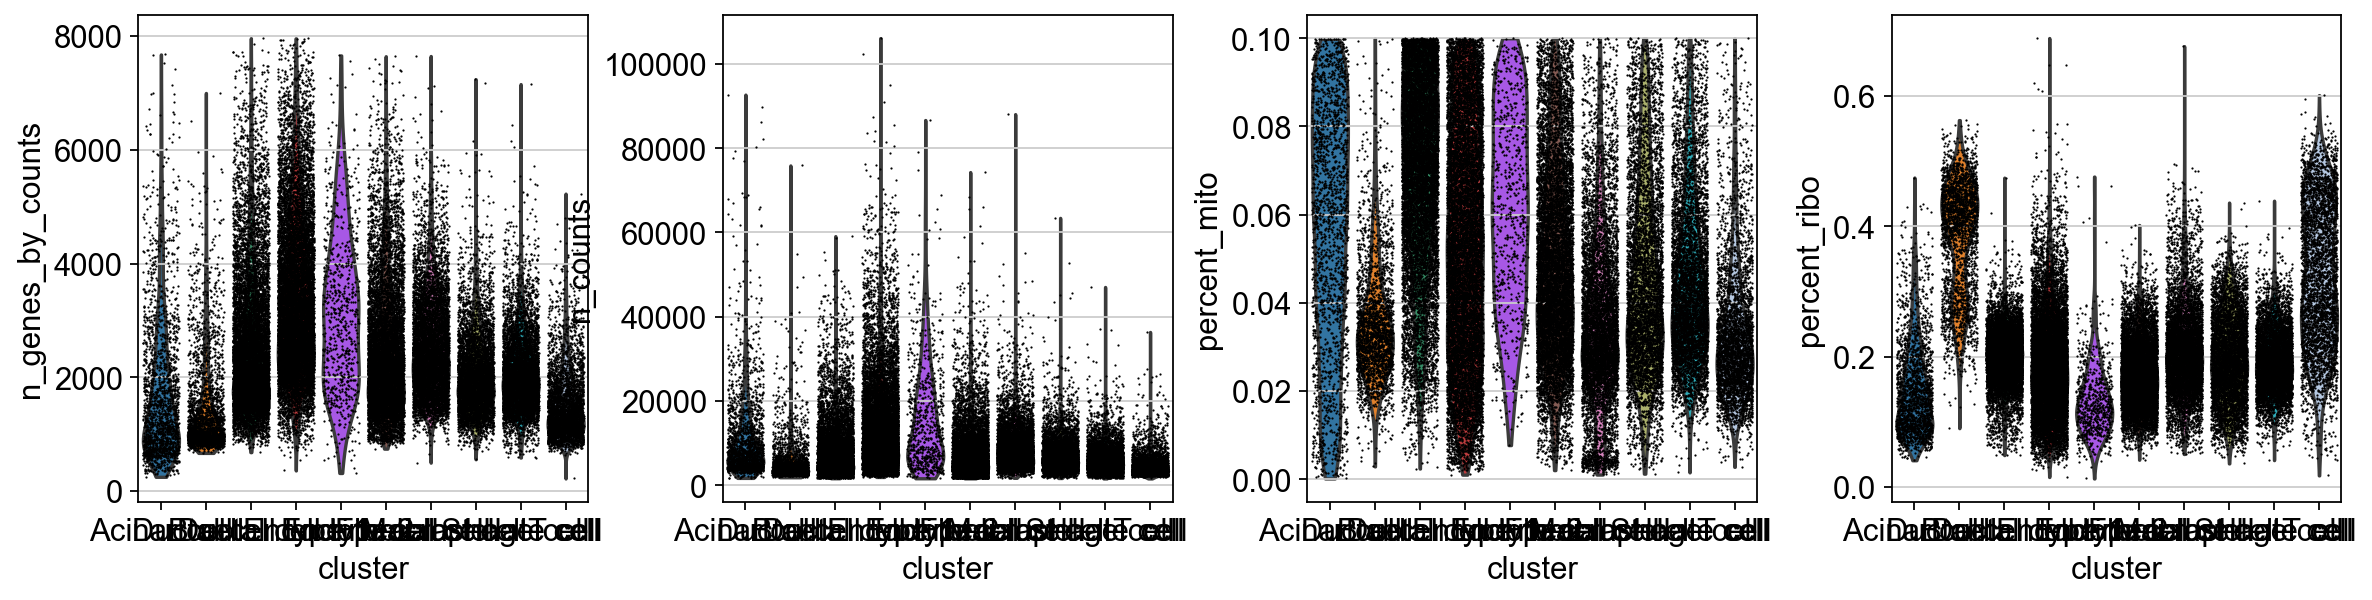

In [12]:
sc.settings.set_figure_params(dpi=80)
sc.pl.violin(adata, ['n_genes_by_counts', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'cluster')

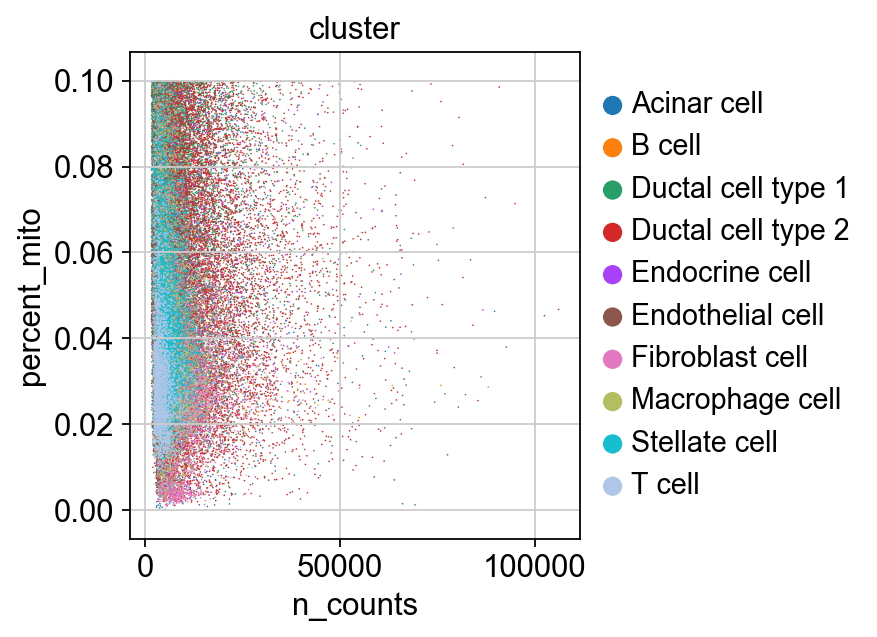

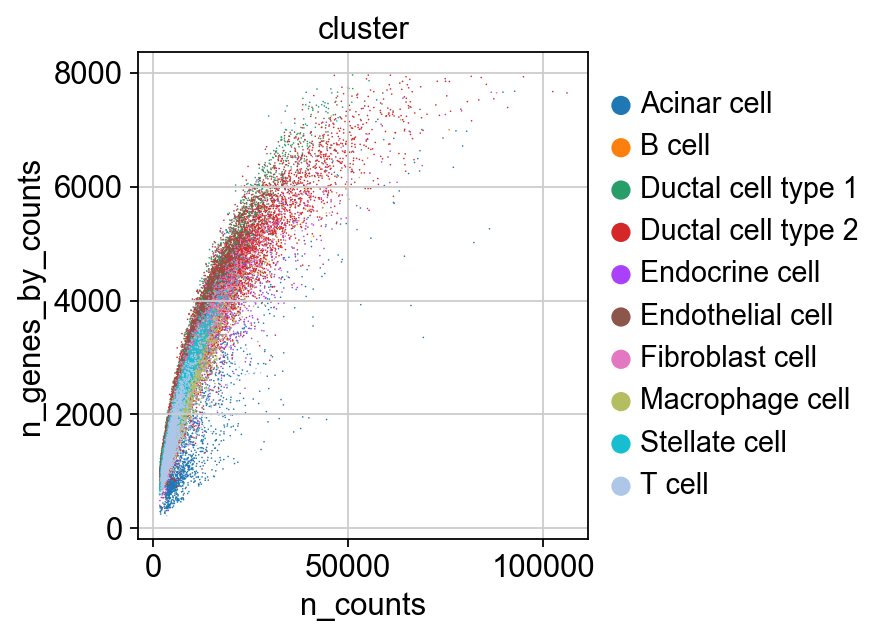

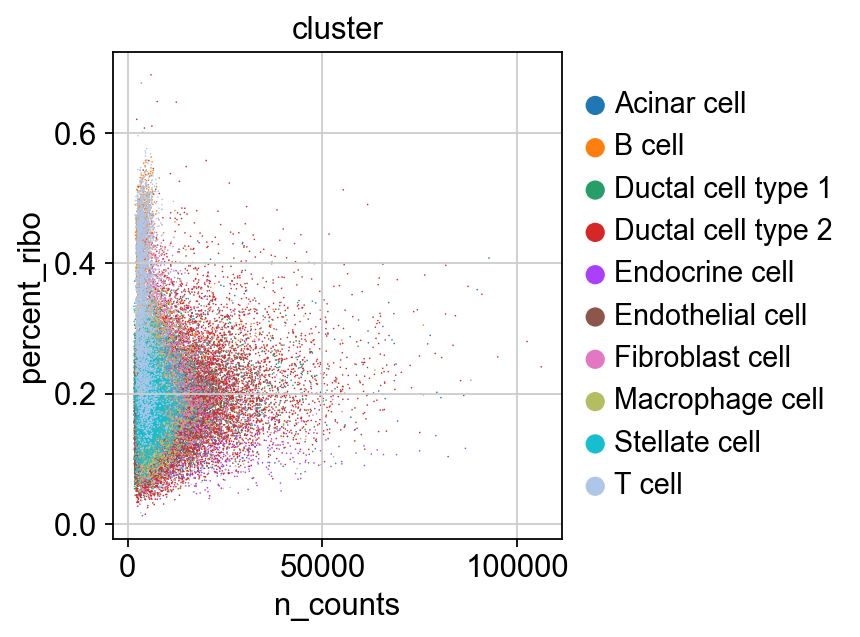

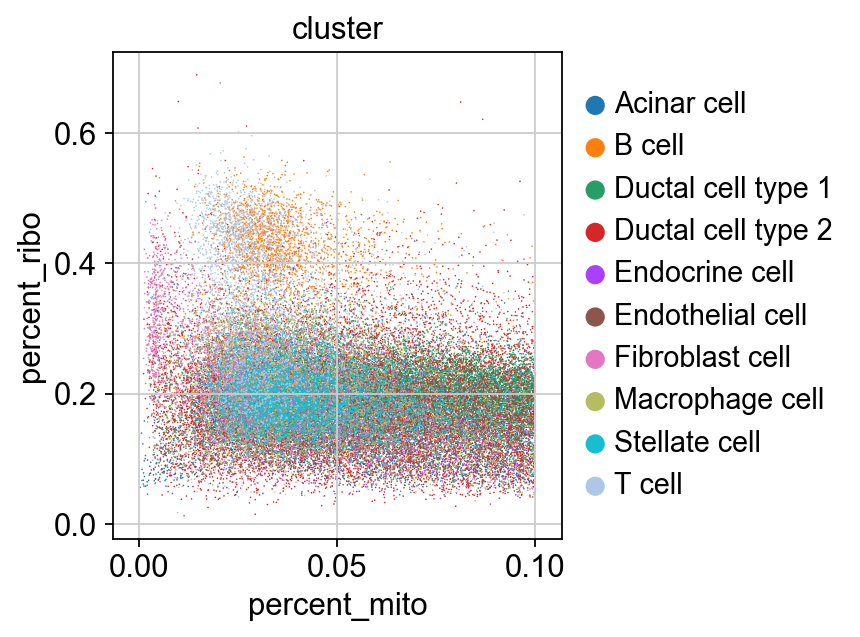

In [13]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', color='cluster')
sc.pl.scatter(adata, x='n_counts', y='n_genes_by_counts', color='cluster')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo', color='cluster')
sc.pl.scatter(adata, x='percent_mito', y='percent_ribo', color='cluster')

### QC1: Include cells with at least 200 detected genes & genes expressed in at least 3 cells

In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print("Remaining cells %d"%adata.n_obs,",", "Remaining genes %d"%adata.n_vars)

Remaining cells 57530 , Remaining genes 23376


### QC2: Use quantile to filter number of genes and counts

In [15]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

864.0 to 5817.419999999998


In [16]:
adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
print("Remaining cells %d"%adata.n_obs,",", "Remaining genes %d"%adata.n_vars)

Remaining cells 55222 , Remaining genes 23376


### QC3: Remove cells with less than 5% ribosomal reads

In [17]:
# filter for percent ribo > 0.05
adata = adata[adata.obs['percent_ribo'] > 0.05, :]
print("Remaining cells %d"%adata.n_obs,",", "Remaining genes %d"%adata.n_vars)

Remaining cells 55113 , Remaining genes 23376


### QC4: Remove MALAT1 genes 

In [18]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
keep = np.invert(malat1)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

55113 23375


/Users/xingliyu/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


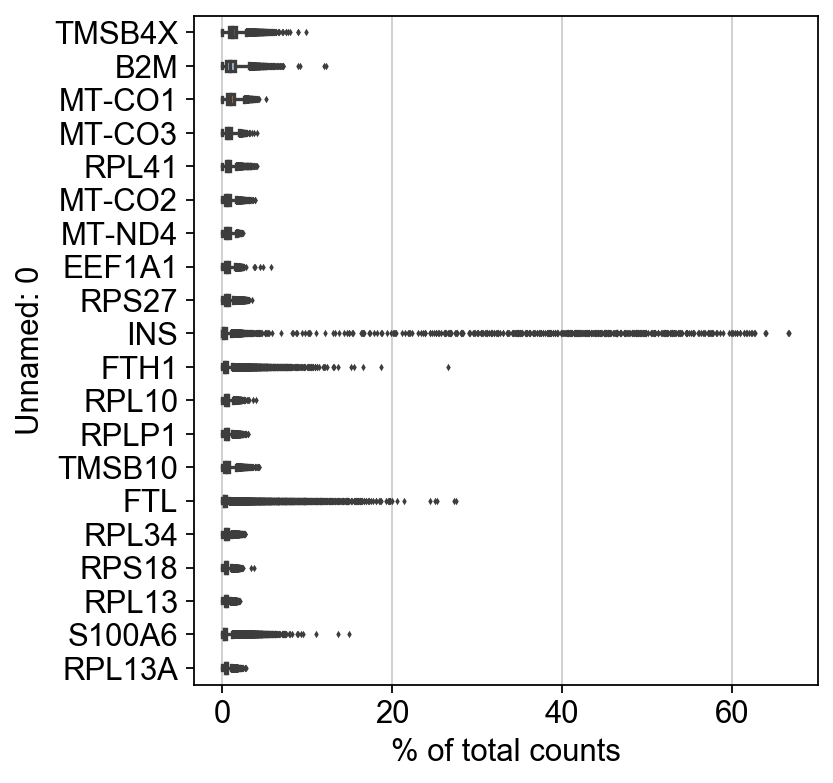

In [19]:
sc.pl.highest_expr_genes(adata, n_top=20, palette='tab20', width=.3)

In [20]:
adata.var['total_expression'] = adata.X.sum(0)
marker_genes = pd.DataFrame(adata.var['total_expression'].nlargest(20))
marker_genes = marker_genes.index.tolist()
marker_genes

['TMSB4X',
 'INS',
 'MT-CO1',
 'B2M',
 'MT-CO3',
 'RPL41',
 'MT-CO2',
 'MT-ND4',
 'FTH1',
 'EEF1A1',
 'S100A6',
 'TMSB10',
 'RPLP1',
 'RPS27',
 'RPL10',
 'FTL',
 'RPS18',
 'RPL34',
 'RPL13',
 'RPL13A']

In [24]:
sc.tl.rank_genes_groups(adata, groupby= "cluster", method='t-test')

/Users/xingliyu/opt/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


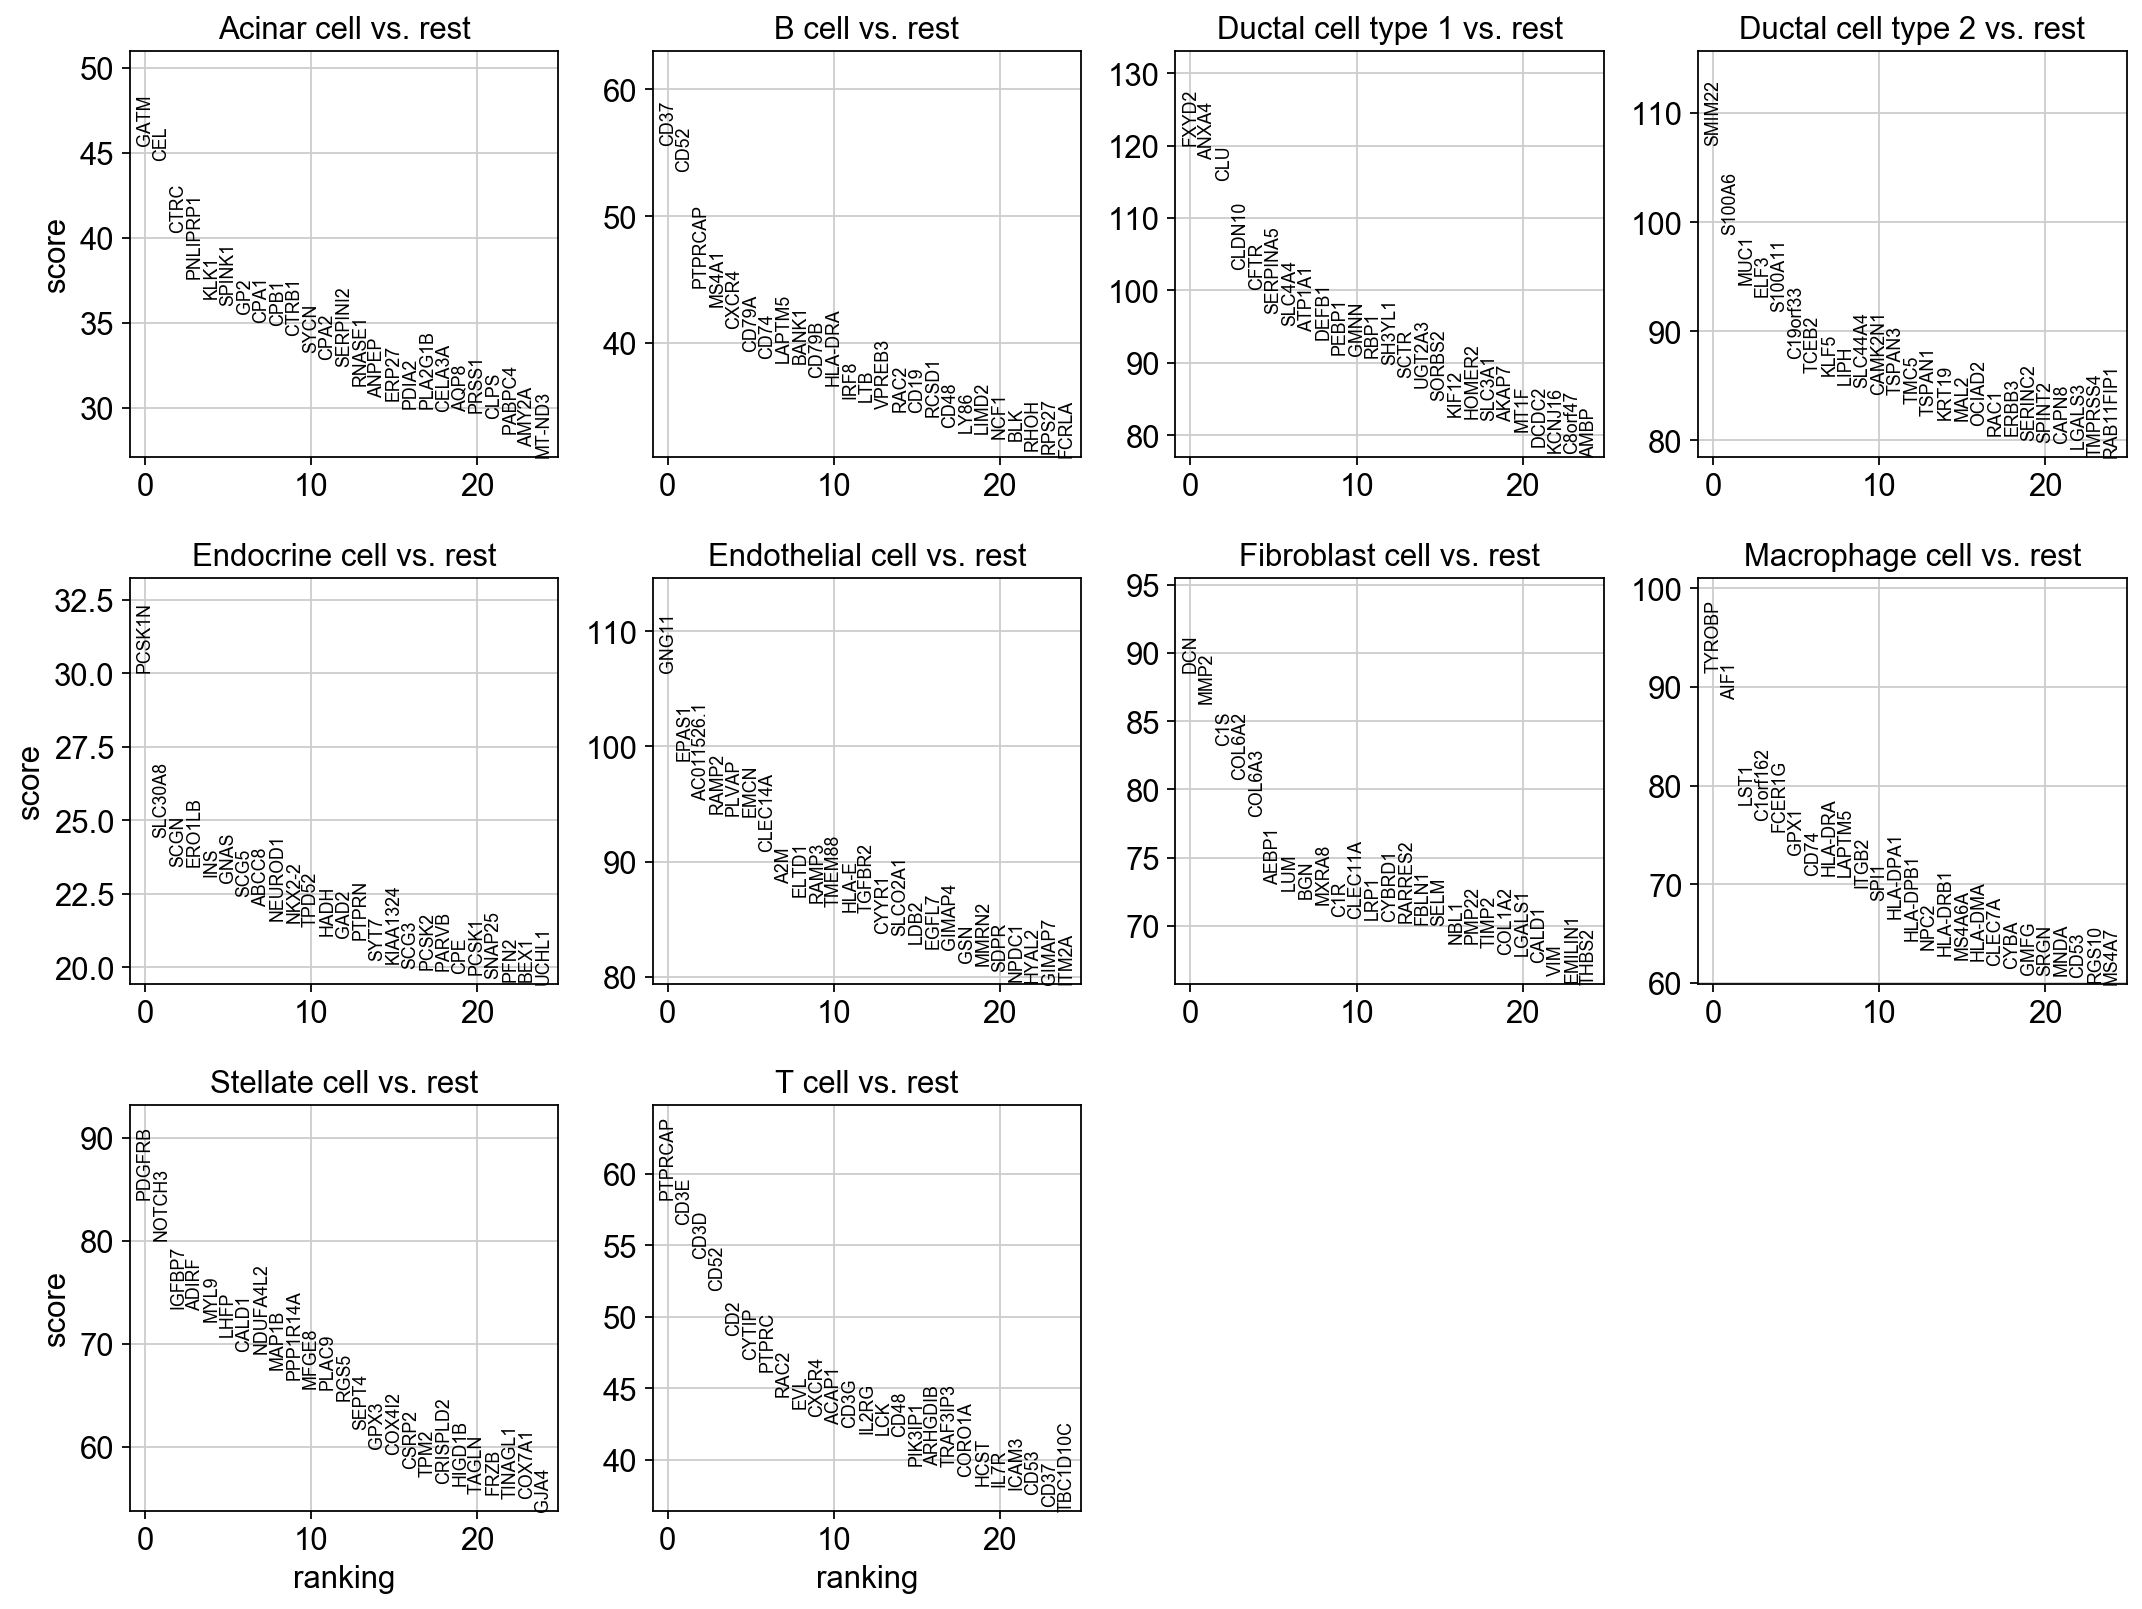

In [25]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [26]:
adata

AnnData object with n_obs × n_vars = 55113 × 23375
    obs: 'cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'percent_mito', 'n_counts', 'percent_ribo', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'total_expression'
    uns: 'cluster_colors', 'rank_genes_groups'

In [27]:
result = adata.uns['rank_genes_groups']
result.keys()
groups = result['names'].dtype.names
data_to_write = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges','pvals_adj']})

In [29]:
data_to_write.head()

Acinar cell_n  Acinar cell_l  Acinar cell_p B cell_n   B cell_l  \
0          GATM      20.711317  5.494247e-276     CD37   8.168641   
1           CEL      77.415100  7.324028e-269     CD52  10.013589   
2          CTRC     259.053589  8.005583e-235  PTPRCAP   8.148952   
3      PNLIPRP1      26.604912  8.180356e-213    MS4A1  12.357018   
4          KLK1      32.267864  4.154651e-203    CXCR4   6.300010   

        B cell_p Ductal cell type 1_n  Ductal cell type 1_l  \
0   0.000000e+00                FXYD2             78.309258   
1   0.000000e+00                ANXA4             32.169300   
2  1.181575e-303                  CLU             36.924831   
3  7.576034e-289               CLDN10             14.348677   
4  7.891958e-274                 CFTR             11.212136   

   Ductal cell type 1_p Ductal cell type 2_n  ...  Fibroblast cell_p  \
0                   0.0               SMIM22  ...                0.0   
1                   0.0               S100A6  ...                0.0   
2                   0.0                 MUC1  ...                0.0   
3                   0.0                 ELF3  ...                0.0   
4                   0.0              S100A11  ...                0.0   

   Macrophage cell_n Macrophage cell_l  Macrophage cell_p  Stellate cell_n  \
0             TYROBP         29.659960                0.0           PDGFRB   
1               AIF1         15.596512                0.0           NOTCH3   
2               LST1          8.520468                0.0           IGFBP7   
3           C1orf162          7.971138                0.0            ADIRF   
4             FCER1G         24.595013                0.0             MYL9   

  Stellate cell_l  Stellate cell_p  T cell_n  T cell_l  T cell_p  
0        8.777416              0.0   PTPRCAP  5.716095       0.0  
1        6.960711              0.0      CD3E  6.457434       0.0  
2       90.571396              0.0      CD3D  7.696309       0.0  
3       29.546814              0.0      CD52  8.675140       0.0  
4       23.108330              0.0       CD2  7.191444       0.0  

[5 rows x 30 columns]

## PCA

In [34]:
adata_norm_pca = adata.copy()

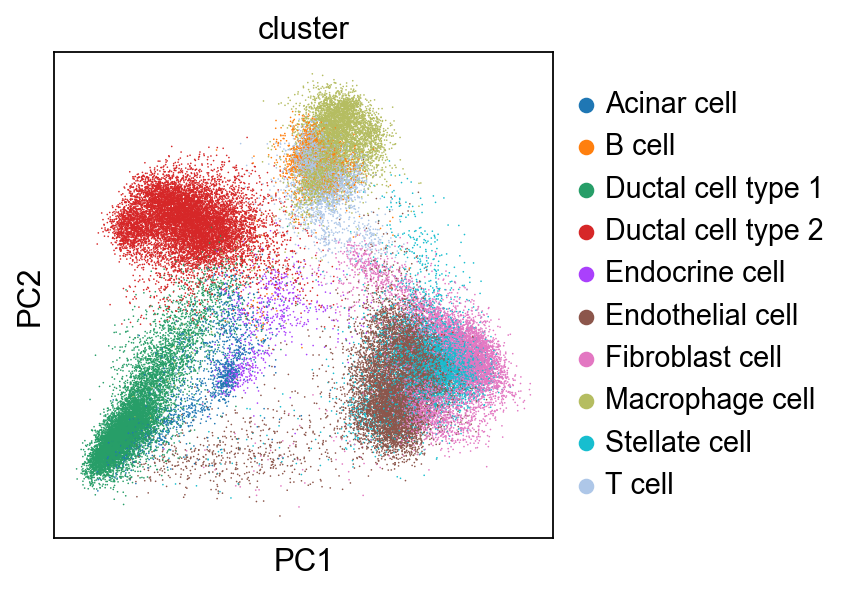

/Users/xingliyu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xingliyu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 8942 missing from current font.
  font.load_char(ord(s), flags=flags)


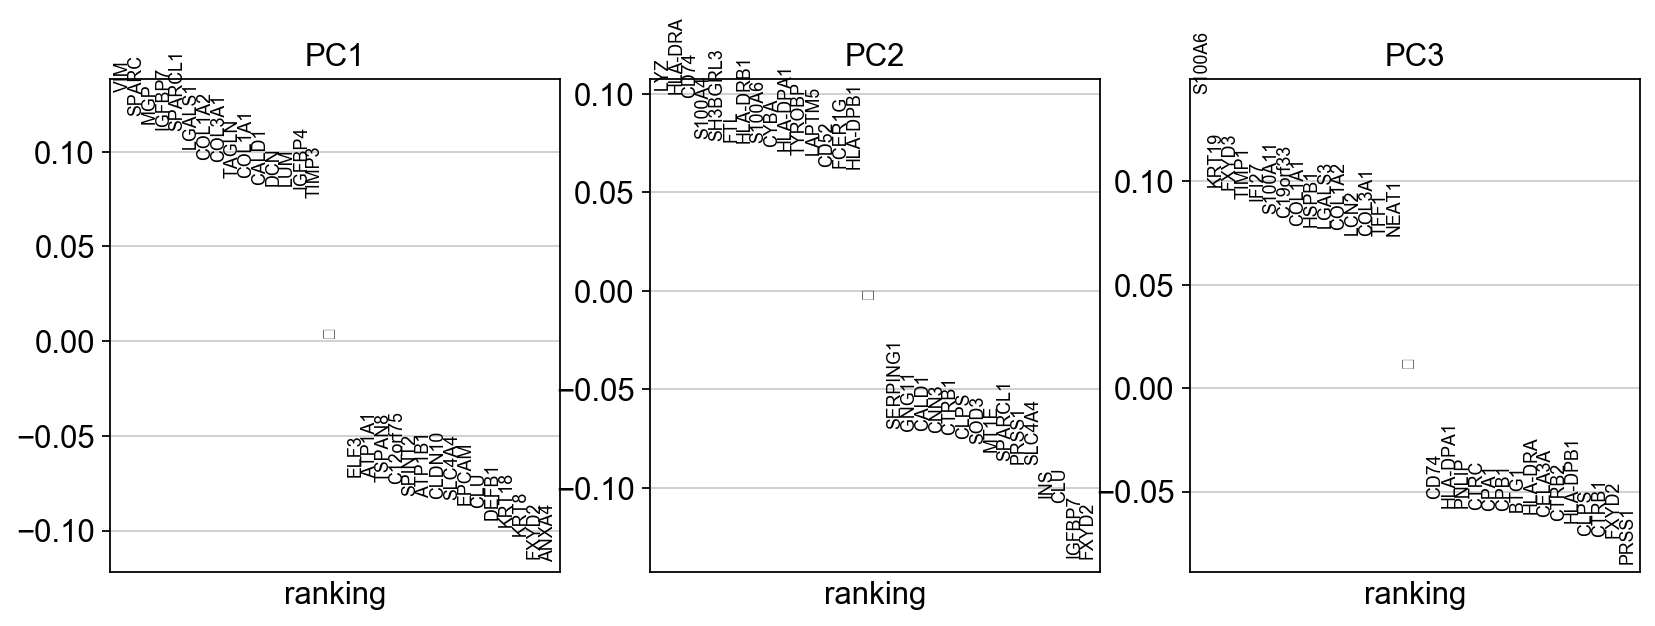

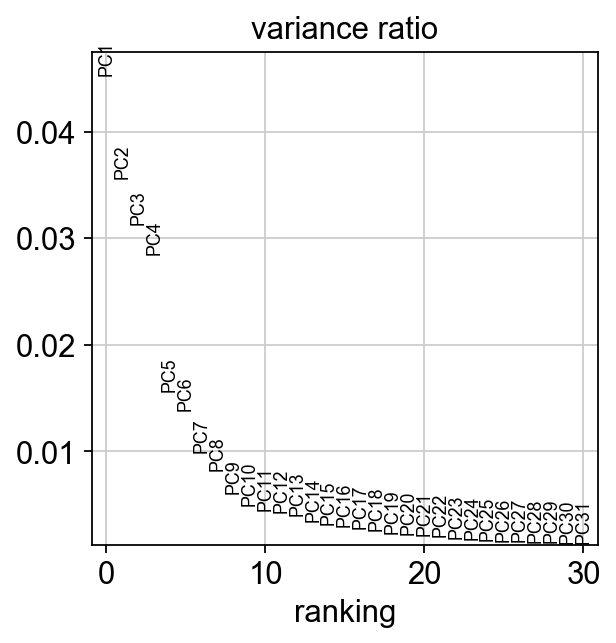

In [35]:
sc.pp.normalize_total(adata_norm_pca, inplace=True)
sc.pp.log1p(adata_norm_pca)
sc.pp.pca(adata_norm_pca)
sc.pl.pca_overview(adata_norm_pca, color='cluster')

## UMAP

In [36]:
adata_umap = adata.copy()

In [37]:
sc.pp.neighbors(adata_umap) # UMAP is based on the neighbor graph; we'll compute this first
sc.tl.umap(adata_umap, random_state=1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


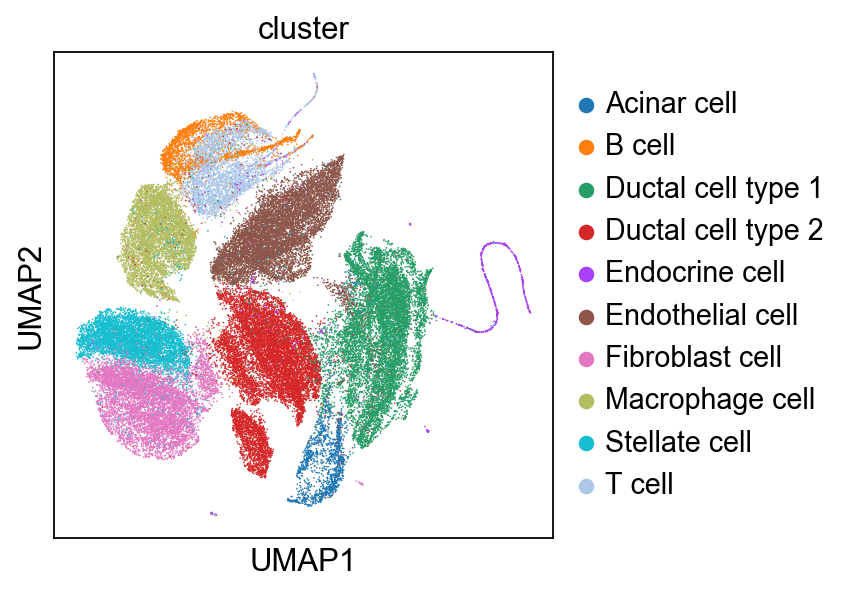

In [38]:
sc.pl.umap(adata_umap, color='cluster')

In [39]:
adata_pca_one = adata.copy() # apply this to a copy so we can compare methods
adata_pca_one.raw = adata_pca_one # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_pca_one, counts_per_cell_after=1e6)

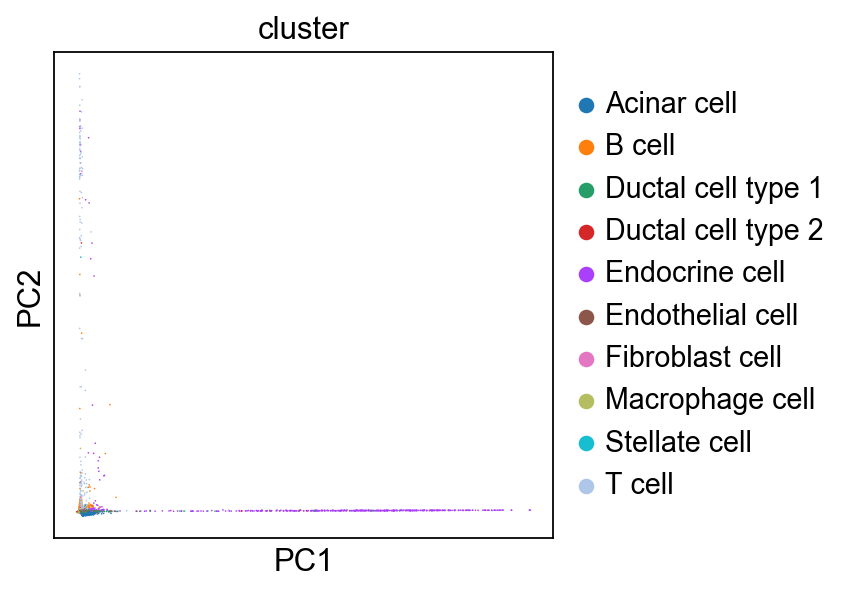

/Users/xingliyu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xingliyu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 8942 missing from current font.
  font.load_char(ord(s), flags=flags)


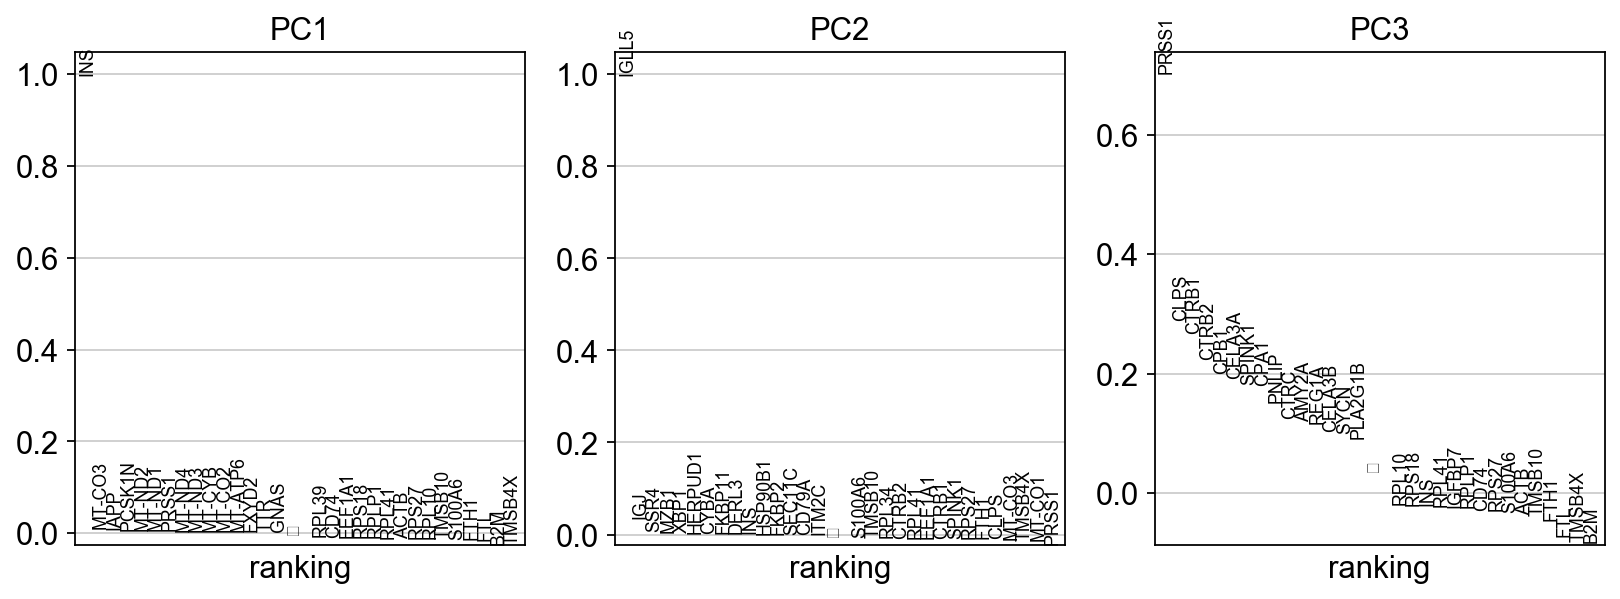

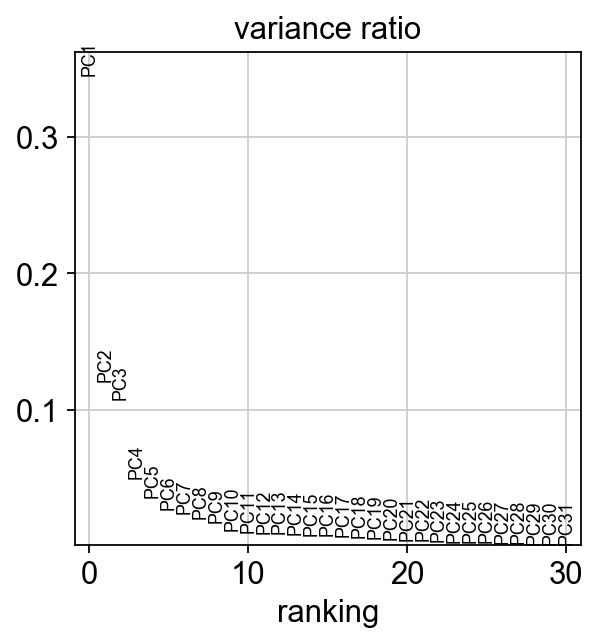

In [40]:
sc.pp.pca(adata_pca_one)
sc.pl.pca_overview(adata_pca_one, color='cluster')

## t-SNE

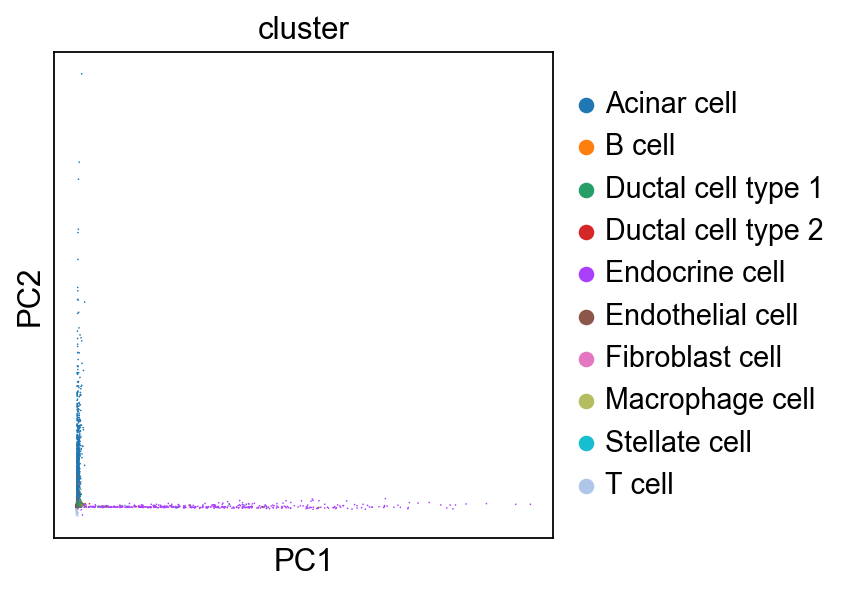

/Users/xingliyu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xingliyu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 8942 missing from current font.
  font.load_char(ord(s), flags=flags)


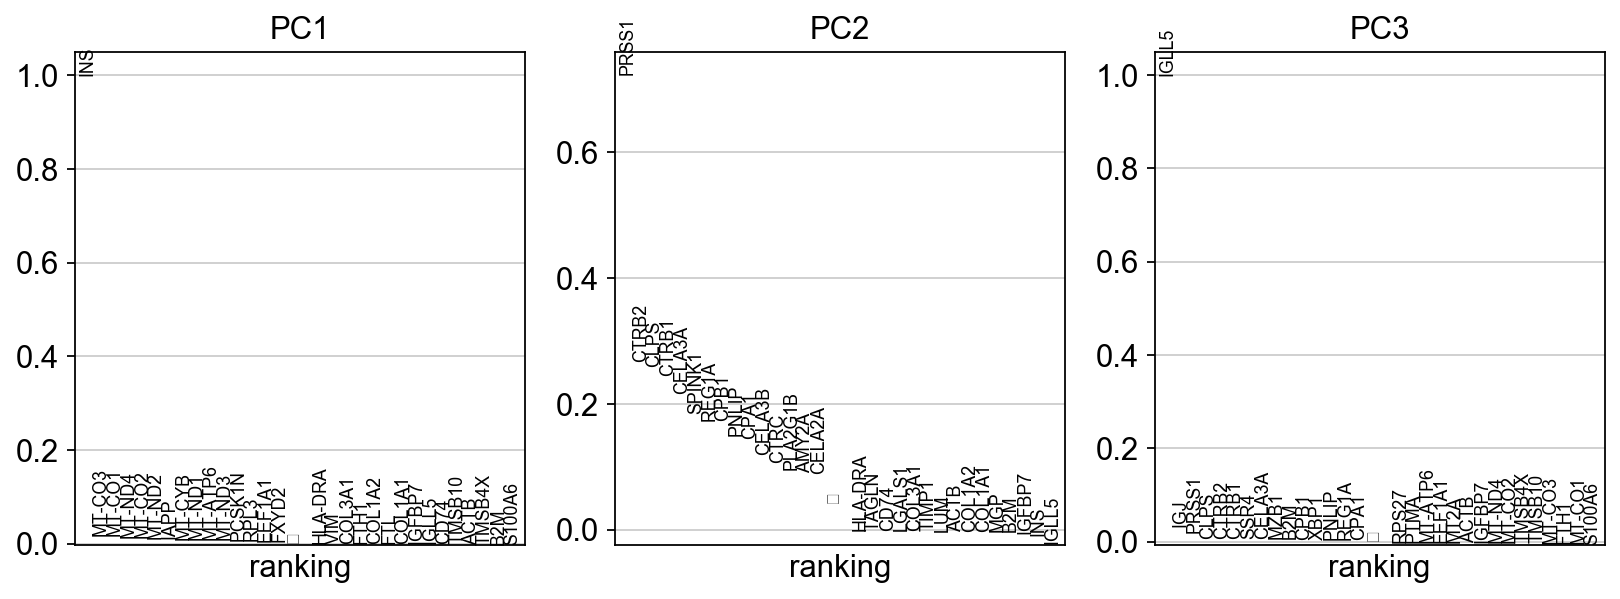

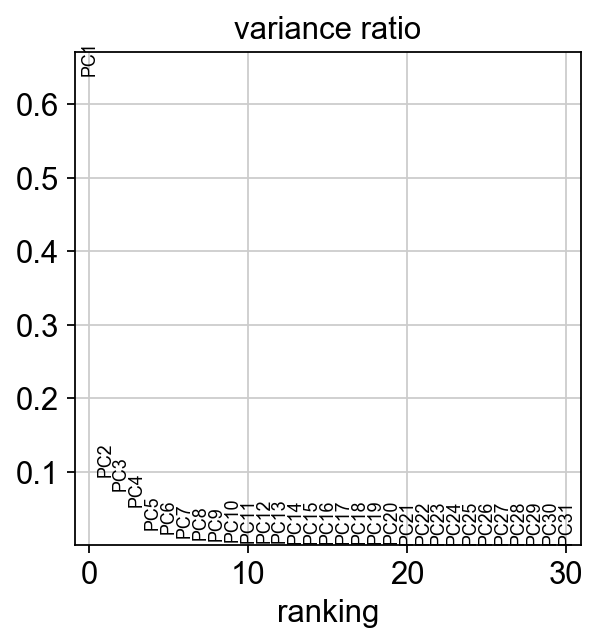

In [41]:
sc.pp.pca(adata)
sc.pl.pca_overview(adata, color='cluster')

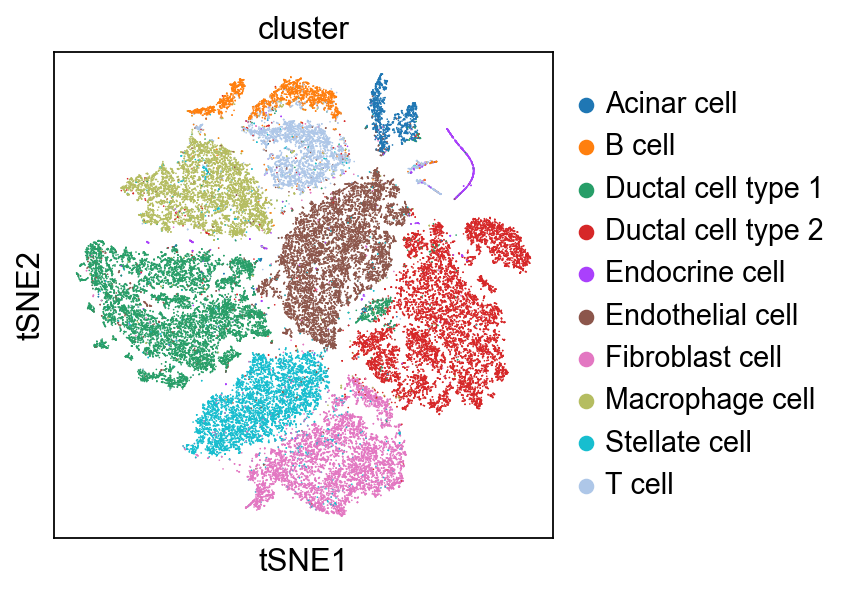

In [42]:
sc.tl.tsne(adata,random_state=42) 
sc.pl.tsne(adata, color='cluster')